In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.style.use('seaborn')

In [3]:
X = 1
n_x = 201
h = 2 * X / (n_x - 1)
tau = 0.5 * h / 2
n_t = 101
xs = np.linspace(-1, X, n_x)

In [4]:
u_l = 1.0
u_r = 0.0
p_l = 5.0
p_r = 2.0
rho = 0.25
c = 2.0

In [5]:
def u_0(x):
    return u_l if x <= 0 else u_r


def p_0(x):
    return p_l if x <= 0 else p_r


def u_t(x, t):
    if x < -c * t:
        return u_l
    elif x > c * t:
        return u_r
    return (u_l + u_r) / 2 - (p_r - p_l) / (2 * rho * c)


def p_t(x, t):
    if x < -c * t:
        return p_l
    elif x > c * t:
        return p_r
    return - rho * c * (u_r - u_l) / 2 + (p_l + p_r) / 2

In [6]:
step = 100

In [7]:
def solve(scheme):
    arr = scheme[1]
    Y = np.zeros((n_t, n_x))
    Z = np.zeros((n_t, n_x))
    
    for i in range(n_x):
        Y[0][i] = u_0(xs[i]) + p_0(xs[i]) / c / rho
        Y[1][i] = u_0(xs[i] - c * tau) + p_0(xs[i] - c * tau) / c / rho
        Z[0][i] = u_0(xs[i]) - p_0(xs[i]) / c / rho
        Z[1][i] = u_0(xs[i] + c * tau) - p_0(xs[i] + c * tau) / c / rho

    for i in range(n_t):
        Y[i][0] = u_t(xs[0], tau * i) + p_t(xs[0], tau * i) / c / rho
        Y[i][-2:] = u_t(xs[-2], tau * i) + p_t(xs[-2], tau * i) / c / rho
        Z[i][0] = u_t(xs[0], tau * i) - p_t(xs[0], tau * i) / c / rho
        Z[i][-2:] = u_t(xs[-2], tau * i) - p_t(xs[-2], tau * i) / c / rho

    for j in range(1, n_t - 1):
        for i in range(1, n_x - 1):
            Y[j + 1][i] = arr[0] * Y[j - 1][i - 2] + arr[1] * Y[j - 1][i] + \
                          arr[2] * Y[j][i - 1] + arr[3] * Y[j][i + 1]
        for i in range(1, n_x - 2):
            Z[j + 1][i] = arr[0] * Z[j - 1][i + 2] + arr[1] * Z[j - 1][i] + \
                          arr[2] * Z[j][i + 1] + arr[3] * Z[j][i - 1]

    _plot(scheme[0], Y[step], Z[step])

In [8]:
def _plot(name, u, v):
    fig = plt.figure(figsize=(15, 20))

    ax1 = fig.add_subplot(211)
    ax1.plot(xs, (u + v) / 2, label='numeric')
    ax1.plot(xs, [u_t(x, step * tau) for x in xs], label='analytic')
    ax1.set_title(f'{name} u', fontsize=20)
    ax1.legend()

    ax2 = fig.add_subplot(212)
    ax2.plot(xs, rho * c * (u - v) / 2, label='numeric')
    ax2.plot(xs, [p_t(x, step * tau) for x in xs], label='analytic')
    ax2.set_title(f'{name} P', fontsize=20)
    ax2.legend()
    
    plt.savefig(f'{name} scheme.png')
    plt.show()

In [9]:
schemes = {'C': [0.0, 1 / 3, 2 / 3, 0.0],
           'Minimum Viscosity': [-0.25, 0.583, 0.917, -0.25]}

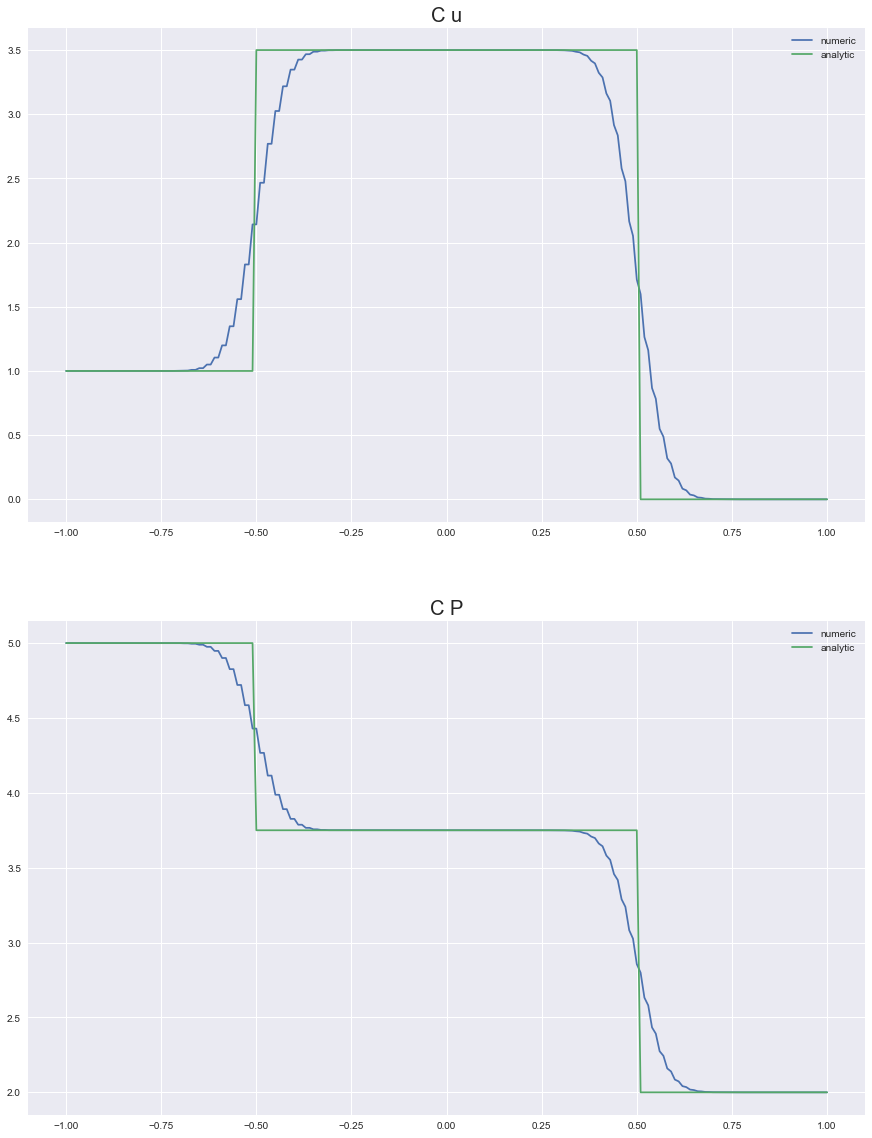

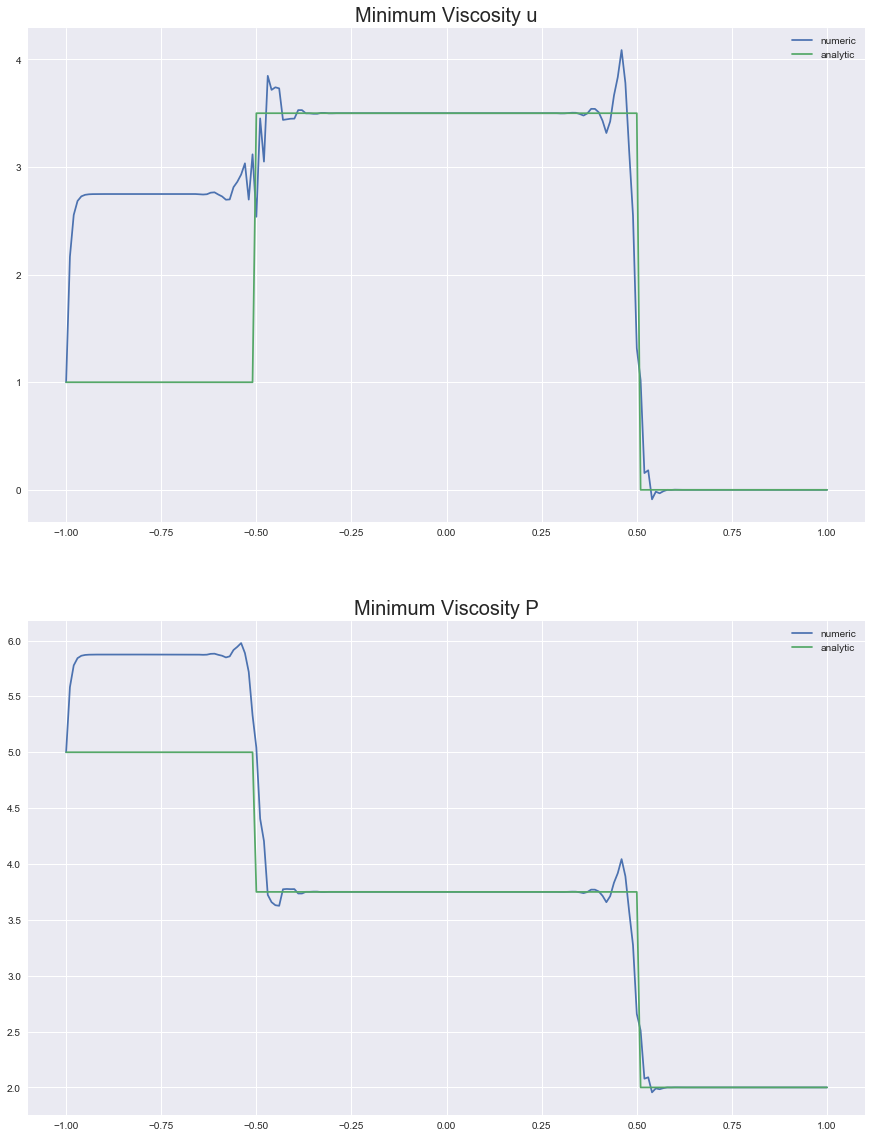

In [10]:
for scheme in schemes.items():
    solve(scheme)

In [11]:
def solve_hybrid(scheme):
    arr1 = scheme[1][0]
    arr2 = scheme[1][1]

    Y = np.zeros((n_t, n_x))
    Z = np.zeros((n_t, n_x))
    
    for i in range(n_x):
        Y[0][i] = u_0(xs[i]) + p_0(xs[i]) / c / rho
        Y[1][i] = u_0(xs[i] - c * tau) + p_0(xs[i] - c * tau) / c / rho
        Z[0][i] = u_0(xs[i]) - p_0(xs[i]) / c / rho
        Z[1][i] = u_0(xs[i] + c * tau) - p_0(xs[i] + c * tau) / c / rho

    for i in range(n_t):
        Y[i][0] = u_t(xs[0], tau * i) + p_t(xs[0], tau * i) / c / rho
        Y[i][-2:] = u_t(xs[-2], tau * i) + p_t(xs[-2], tau * i) / c / rho
        Z[i][0] = u_t(xs[0], tau * i) - p_t(xs[0], tau * i) / c / rho
        Z[i][-2:] = u_t(xs[-2], tau * i) - p_t(xs[-2], tau * i) / c / rho
        
    for j in range(1, n_t - 1):
        
        for i in range(1, n_x - 1):
            Y[j + 1][i] = arr1[0] * Y[j - 1][i - 2] + arr1[1] * Y[j - 1][i] + \
                          arr1[2] * Y[j][i - 1] + arr1[3] * Y[j][i + 1]
            if not min(Y[j][i - 1], Y[j - 1][i]) <= Y[j + 1][i] <= max(Y[j][i - 1], Y[j - 1][i]):
                Y[j + 1][i] = arr2[0] * Y[j - 1][i - 2] + arr2[1] * Y[j - 1][i] + \
                          arr2[2] * Y[j][i - 1] + arr2[3] * Y[j][i + 1]
                
            if not min(Y[j][i - 1], Y[j - 1][i]) <= Y[j + 1][i] <= max(Y[j][i - 1], Y[j - 1][i]):
                if Y[j + 1][i] >= max(np.array([Y[j][i - 1], Y[j - 1][i]])):
                    Y[j + 1][i] = max(np.array([Y[j][i - 1], Y[j - 1][i]]))
                else:
                    Y[j + 1][i] = min(np.array([Y[j][i - 1], Y[j - 1][i]]))
            
        for i in range(1, n_x - 2):
            Z[j + 1][i] = arr1[0] * Z[j - 1][i + 2] + arr1[1] * Z[j - 1][i] + \
                          arr1[2] * Z[j][i + 1] + arr1[3] * Z[j][i - 1]
            if not min(Z[j][i + 1], Z[j - 1][i]) <= Z[j + 1][i] <= max(Z[j][i + 1], Z[j - 1][i]):
                Z[j + 1][i] = arr2[0] * Z[j - 1][i + 2] + arr2[1] * Z[j - 1][i] + \
                          arr2[2] * Z[j][i + 1] + arr2[3] * Z[j][i - 1]
                
            if not min(Z[j][i + 1], Z[j - 1][i]) <= Z[j + 1][i] <= max(Z[j][i + 1], Z[j - 1][i]):
                if Z[j + 1][i] >= max(np.array([Z[j][i + 1], Z[j - 1][i]])):
                    Z[j + 1][i] = max(np.array([Z[j][i + 1], Z[j - 1][i]]))
                else:
                    Z[j + 1][i] = min(np.array([Z[j][i + 1], Z[j - 1][i]]))

    _plot(scheme[0], Y[step], Z[step])

In [12]:
def a_2(b, c):
    return 3 / 5 - 1 / 5 * b - 4 / 5 * c


def d_2(b, c):
    return 2 / 5 - 4 / 5 * b - 1 / 5 * c


schemes = {'Minimum Viscosity': [-0.25, 0.583, 0.917, -0.25],
           'Minimum Viscosity +': [a_2(0.5, 1), 0.5, 1, d_2(0.5, 1)],
           'Minimum Viscosity -': [a_2(0.6, 0.9), 0.6, 0.9, d_2(0.6, 0.9)],
           'O^3': [-0.3, 0.5, 1.0, -0.2]}

hybrid = {'7p': [schemes['Minimum Viscosity -'],schemes['Minimum Viscosity +'], schemes['O^3']]}

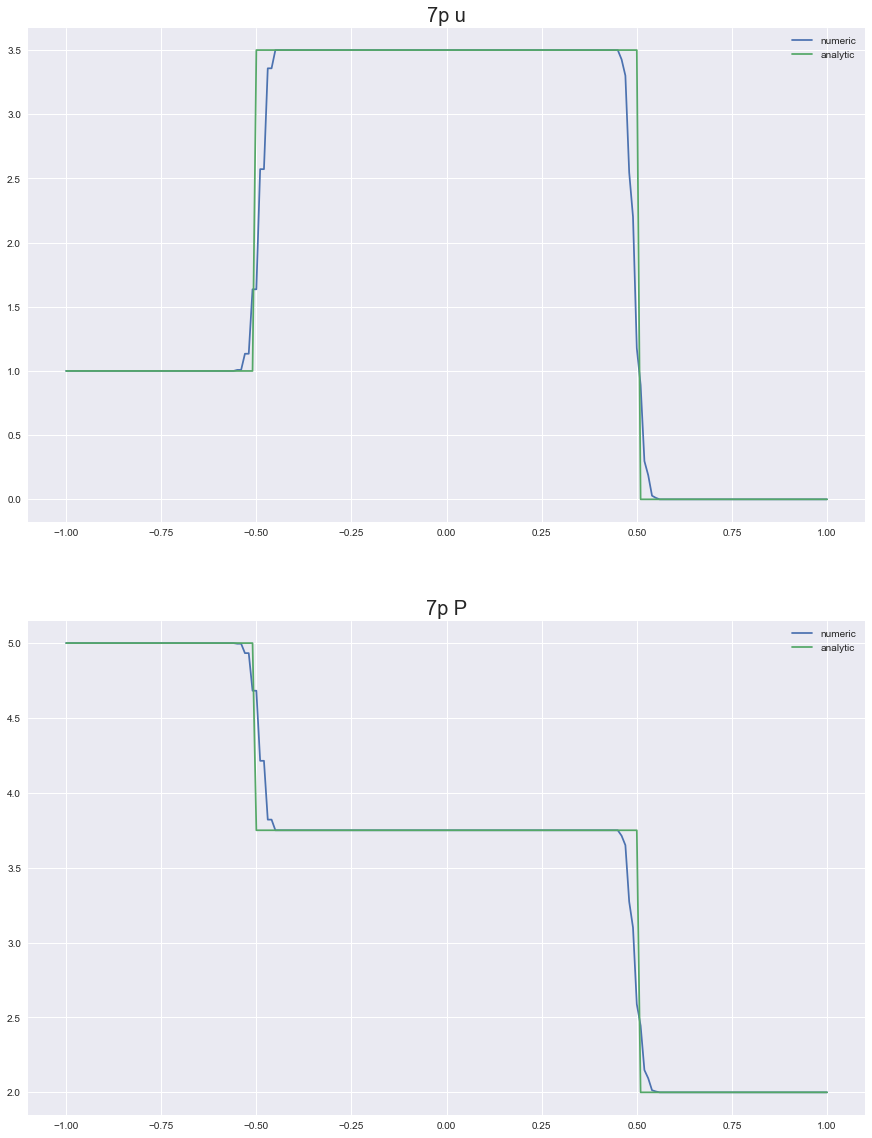

In [13]:
for scheme in hybrid.items():
    solve_hybrid(scheme)